In [45]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout, BatchNorm1d, ModuleList
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_mean_pool, global_max_pool, global_add_pool, to_hetero
from torch_geometric.data import Data, HeteroData, Dataset, DataLoader
from torch_geometric.transforms import ToUndirected, NormalizeFeatures
from torch_geometric.utils import train_test_split_edges, negative_sampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Используется устройство: cuda


Установим seed для воспроизводимости

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
df = pd.read_excel('datasets/FinalDataset.xlsx')

df['is_scam'] = (df['from_scam'] == 1) | (df['to_scam'] == 1)
df['is_scam'] = df['is_scam'].astype(int)

In [5]:
def create_transaction_graph(df, use_node_features=False, use_edge_features=True):
    """
    Создает граф транзакций Ethereum
    
    Параметры:
    - use_node_features: добавлять ли признаки узлов (адресов)
    - use_edge_features: добавлять ли признаки ребер (транзакций)
    """
    
    all_addresses = pd.concat([df['from_address'], df['to_address']]).unique()
    address_to_idx = {addr: idx for idx, addr in enumerate(all_addresses)}
    
    edge_index = torch.tensor([
        [address_to_idx[addr] for addr in df['from_address']],
        [address_to_idx[addr] for addr in df['to_address']]
    ], dtype=torch.long)
    
    print(f"Узлов (адресов): {len(all_addresses):,}")
    print(f"Ребер (транзакций): {edge_index.shape[1]:,}")
    
    edge_attr = None
    if use_edge_features:
        print("Создание признаков ребер...")
        
        edge_features = [
            'value', 'gas', 'gas_price', 'receipt_gas_used'
        ]
        
        df_processed = df.copy()
        
        df_processed['gas_efficiency'] = df_processed['receipt_gas_used'] / df_processed['gas']
        df_processed['gas_efficiency'] = df_processed['gas_efficiency'].replace([np.inf, -np.inf], 1.0)
        df_processed['gas_efficiency'] = df_processed['gas_efficiency'].fillna(1.0)
        
        df_processed['gas_cost'] = df_processed['gas_price'] * df_processed['receipt_gas_used'] / 1e18
        
        for col in ['value', 'gas', 'gas_price']:
            if col in df_processed.columns:
                df_processed[f'log_{col}'] = np.log1p(df_processed[col])
        
        final_edge_features = [
            'log_value', 'log_gas', 'log_gas_price',
            'receipt_gas_used', 'gas_efficiency', 'gas_cost'
        ]
        
        edge_features_list = []
        for feat in final_edge_features:
            if feat in df_processed.columns:
                feat_values = df_processed[feat].values.astype(np.float32)
                edge_features_list.append(feat_values.reshape(-1, 1))
        
        if edge_features_list:
            edge_attr = np.hstack(edge_features_list)
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)
            print(f"Признаков ребер: {edge_attr.shape[1]}")
        else:
            edge_attr = torch.ones((edge_index.shape[1], 1), dtype=torch.float)
            print("Используются единичные признаки ребер")
    
    x = None
    if use_node_features:
        print("Создание признаков узлов...")
        
        node_stats = []
        
        for addr_idx, addr in enumerate(all_addresses):
            from_mask = df['from_address'] == addr
            to_mask = df['to_address'] == addr
            
            features = []
            
            features.append(from_mask.sum())
            features.append(to_mask.sum())
            
            if from_mask.any():
                features.append(df.loc[from_mask, 'value'].mean())
                features.append(df.loc[from_mask, 'value'].std() if from_mask.sum() > 1 else 0)
                features.append(df.loc[from_mask, 'gas_price'].mean())
            else:
                features.extend([0, 0, 0])
                
            if to_mask.any():
                features.append(df.loc[to_mask, 'value'].mean())
                features.append(df.loc[to_mask, 'value'].std() if to_mask.sum() > 1 else 0)
            else:
                features.extend([0, 0])
            
            node_stats.append(features)
        
        x = torch.tensor(node_stats, dtype=torch.float)
        
        x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-8)
        
        print(f"Признаков узлов: {x.shape[1]}")
    else:
        x = torch.ones((len(all_addresses), 1), dtype=torch.float)
        print("Используются единичные признаки узлов")
    
    y = torch.tensor(df['is_scam'].values, dtype=torch.float).view(-1, 1)
    
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        num_nodes=len(all_addresses)
    )
    
    data.edge_index_with_labels = torch.arange(edge_index.shape[1], dtype=torch.long)
    
    print(f"\nСводка графа:")
    print(f" • Узлов: {data.num_nodes:,}")
    print(f" • Ребер: {data.num_edges:,}")
    print(f" • Признаков узлов: {data.num_node_features}")
    print(f" • Признаков ребер: {data.edge_attr.shape[1] if data.edge_attr is not None else 0}")
    print(f" • Меток: {data.y.shape[0]:,}")
    
    return data

In [6]:
graph_data = create_transaction_graph(df, use_node_features=True, use_edge_features=True)
graph_data = graph_data.to(device)

Узлов (адресов): 73,034
Ребер (транзакций): 71,250
Создание признаков ребер...
Признаков ребер: 6
Создание признаков узлов...
Признаков узлов: 7

Сводка графа:
 • Узлов: 73,034
 • Ребер: 71,250
 • Признаков узлов: 7
 • Признаков ребер: 6
 • Меток: 71,250


In [7]:
def split_edges_by_transactions(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Разделяет ребра графа на обучающую, валидационную и тестовую выборки"""
    
    num_edges = data.edge_index.shape[1]
    indices = np.arange(num_edges)
    
    np.random.shuffle(indices)
    
    train_end = int(train_ratio * num_edges)
    val_end = train_end + int(val_ratio * num_edges)
    
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]
    
    train_mask = torch.zeros(num_edges, dtype=torch.bool)
    val_mask = torch.zeros(num_edges, dtype=torch.bool)
    test_mask = torch.zeros(num_edges, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    data.train_mask = train_mask.to(device)
    data.val_mask = val_mask.to(device)
    data.test_mask = test_mask.to(device)
    
    print(f"Обучающая выборка: {train_mask.sum().item():,} ребер ({train_ratio*100:.0f}%)")
    print(f"Валидационная выборка: {val_mask.sum().item():,} ребер ({val_ratio*100:.0f}%)")
    print(f"Тестовая выборка: {test_mask.sum().item():,} ребер ({test_ratio*100:.0f}%)")
    
    print(f"\nРаспределение классов по выборкам:")
    for name, mask in [("Обучающая", train_mask), ("Валидационная", val_mask), ("Тестовая", test_mask)]:
        if mask.sum() > 0:
            scam_ratio = data.y[mask].mean().item()
            print(f"{name}: {data.y[mask].sum().item():.0f} аномалий ({scam_ratio*100:.1f}%)")
    
    return data

In [8]:
graph_data = split_edges_by_transactions(graph_data)

Обучающая выборка: 49,875 ребер (70%)
Валидационная выборка: 10,687 ребер (15%)
Тестовая выборка: 10,688 ребер (15%)

Распределение классов по выборкам:
Обучающая: 9991 аномалий (20.0%)
Валидационная: 2193 аномалий (20.5%)
Тестовая: 2066 аномалий (19.3%)


In [9]:
class EdgeClassifierGNN(torch.nn.Module):
    """GNN для классификации ребер (транзакций)"""
    
    def __init__(self, num_node_features, num_edge_features, hidden_channels=128, 
                 num_layers=3, dropout=0.3, gnn_type='GAT'):
        super().__init__()
        
        self.gnn_type = gnn_type
        self.dropout = dropout
        
        self.node_layers = ModuleList()
        
        self.node_layers.append(Linear(num_node_features, hidden_channels))
        
        self.convs = ModuleList()
        current_channels = hidden_channels
        
        for i in range(num_layers):
            if gnn_type == 'GAT':
                conv = GATConv(current_channels, hidden_channels // 8, heads=8, dropout=dropout)
                current_channels = hidden_channels
            elif gnn_type == 'GCN':
                conv = GCNConv(current_channels, hidden_channels)
                current_channels = hidden_channels
            elif gnn_type == 'SAGE':
                conv = SAGEConv(current_channels, hidden_channels)
                current_channels = hidden_channels
            else:
                raise ValueError(f"Unknown GNN type: {gnn_type}")
            
            self.convs.append(conv)
        
        self.edge_encoder = Linear(num_edge_features, hidden_channels)
        
        edge_hidden = hidden_channels * 3
        
        self.edge_classifier = torch.nn.Sequential(
            Linear(edge_hidden, hidden_channels),
            BatchNorm1d(hidden_channels),
            torch.nn.ReLU(),
            Dropout(dropout),
            Linear(hidden_channels, hidden_channels // 2),
            BatchNorm1d(hidden_channels // 2),
            torch.nn.ReLU(),
            Dropout(dropout),
            Linear(hidden_channels // 2, 1)
        )
        
        self.batch_norms = ModuleList([BatchNorm1d(hidden_channels) for _ in range(num_layers)])
        
        print(f"Создана модель {gnn_type}-GNN:")
        print(f"• Входные признаки узлов: {num_node_features}")
        print(f"• Входные признаки ребер: {num_edge_features}")
        print(f"• Скрытая размерность: {hidden_channels}")
        print(f"• Количество слоев: {num_layers}")
        print(f"• Dropout: {dropout}")
    
    def forward(self, x, edge_index, edge_attr):
        x = self.node_layers[0](x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        for conv, bn in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        edge_features = self.edge_encoder(edge_attr)
        edge_features = F.relu(edge_features)
        
        src, dst = edge_index[0], edge_index[1]
        
        src_features = x[src]
        dst_features = x[dst]
        
        combined_features = torch.cat([src_features, dst_features, edge_features], dim=1)
        
        edge_pred = self.edge_classifier(combined_features)
        
        return edge_pred
    
    def predict_edge(self, x, edge_index, edge_attr, src_idx, dst_idx):
        """Предсказание для конкретного ребра"""
        with torch.no_grad():
            edge_pred = self.forward(x, edge_index, edge_attr)
            mask = (edge_index[0] == src_idx) & (edge_index[1] == dst_idx)
            if mask.any():
                return torch.sigmoid(edge_pred[mask])
        return torch.tensor([0.5])

In [37]:
num_node_features = graph_data.num_node_features
num_edge_features = graph_data.edge_attr.shape[1] if graph_data.edge_attr is not None else 1

model = EdgeClassifierGNN(
    num_node_features=num_node_features,
    num_edge_features=num_edge_features,
    hidden_channels=128,
    num_layers=3,
    dropout=0.2,
    gnn_type='GAT'
).to(device)

Создана модель GAT-GNN:
• Входные признаки узлов: 7
• Входные признаки ребер: 6
• Скрытая размерность: 128
• Количество слоев: 3
• Dropout: 0.2


In [38]:
print("\nАрхитектура модели:")
print(model)
print(f"Всего параметров: {sum(p.numel() for p in model.parameters()):,}")


Архитектура модели:
EdgeClassifierGNN(
  (node_layers): ModuleList(
    (0): Linear(in_features=7, out_features=128, bias=True)
  )
  (convs): ModuleList(
    (0-2): 3 x GATConv(128, 16, heads=8)
  )
  (edge_encoder): Linear(in_features=6, out_features=128, bias=True)
  (edge_classifier): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Всего параметров: 110,977


In [39]:
class WeightedBCELoss(torch.nn.Module):
    """Weighted Binary Cross Entropy Loss для несбалансированных данных"""
    
    def __init__(self, pos_weight=1.0):
        super().__init__()
        self.pos_weight = pos_weight
    
    def forward(self, predictions, targets):
        batch_size = targets.size(0)
        pos_count = targets.sum().item()
        neg_count = batch_size - pos_count
        
        if pos_count > 0 and neg_count > 0:
            weight = targets * (neg_count / pos_count) * self.pos_weight + (1 - targets)
        else:
            weight = torch.ones_like(targets)
        
        loss = F.binary_cross_entropy_with_logits(
            predictions, targets, weight=weight, reduction='mean'
        )
        return loss

def train_epoch(model, data, optimizer, criterion, epoch):
    """Одна эпоха обучения"""
    model.train()
    optimizer.zero_grad()
    
    train_edges = data.edge_index[:, data.train_mask]
    train_edge_attr = data.edge_attr[data.train_mask] if data.edge_attr is not None else None
    train_targets = data.y[data.train_mask]
    
    out = model(data.x, train_edges, train_edge_attr)
    
    loss = criterion(out, train_targets)
    
    loss.backward()
    optimizer.step()
    
    preds = (torch.sigmoid(out) > 0.5).float()
    accuracy = (preds == train_targets).float().mean()
    
    return loss.item(), accuracy.item()

def validate(model, data, mask, criterion):
    """Валидация модели"""
    model.eval()
    with torch.no_grad():
        val_edges = data.edge_index[:, mask]
        val_edge_attr = data.edge_attr[mask] if data.edge_attr is not None else None
        val_targets = data.y[mask]
        
        out = model(data.x, val_edges, val_edge_attr)
        
        loss = criterion(out, val_targets)
        
        preds_proba = torch.sigmoid(out)
        preds = (preds_proba > 0.5).float()
        
        accuracy = (preds == val_targets).float().mean()
        
        try:
            auc = roc_auc_score(val_targets.cpu().numpy(), preds_proba.cpu().numpy())
            f1 = f1_score(val_targets.cpu().numpy(), preds.cpu().numpy())
        except:
            auc, f1 = 0.0, 0.0
        
        return loss.item(), accuracy.item(), auc, f1

def train_model(model, data, num_epochs=100, lr=0.001, patience=20):
    """Полный цикл обучения модели"""
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    pos_count = data.y[data.train_mask].sum().item()
    neg_count = data.train_mask.sum().item() - pos_count
    pos_weight = max(1.0, neg_count / (pos_count + 1e-7))
    
    criterion = WeightedBCELoss(pos_weight=pos_weight)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )
    
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': []
    }
    
    print(f"\nНачинаем обучение на {num_epochs} эпох...")
    print(f"Размерность данных: {data.x.shape}")
    print(f"Положительных примеров в обучении: {pos_count:,} ({pos_count/data.train_mask.sum().item()*100:.1f}%)")
    print(f"Вес положительного класса: {pos_weight:.2f}")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, data, optimizer, criterion, epoch)
        
        val_loss, val_acc, val_auc, val_f1 = validate(model, data, data.val_mask, criterion)
        
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        history['val_f1'].append(val_f1)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_auc': val_auc,
            }, 'best_gnn_model.pth')
        else:
            patience_counter += 1
        
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Эпоха {epoch:3d}/{num_epochs}: "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}, F1: {val_f1:.4f}")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping на эпохе {epoch}")
            break
    
    checkpoint = torch.load('best_gnn_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"\nЛучшая модель на эпохе {best_epoch}:")
    print(f"Val Loss: {best_val_loss:.4f}, AUC: {history['val_auc'][best_epoch]:.4f}")
    
    return model, history

In [40]:
num_epochs = 100
learning_rate = 0.001

model, history = train_model(
    model, graph_data, 
    num_epochs=num_epochs, 
    lr=learning_rate, 
    patience=60
)


Начинаем обучение на 100 эпох...
Размерность данных: torch.Size([73034, 7])
Положительных примеров в обучении: 9,991.0 (20.0%)
Вес положительного класса: 3.99
Эпоха   0/100: Train Loss: 3.0152, Acc: 0.8035 | Val Loss: 4.8919, Acc: 0.7948, AUC: 0.2235, F1: 0.0000
Эпоха  10/100: Train Loss: 2.5143, Acc: 0.8463 | Val Loss: 2.6052, Acc: 0.8430, AUC: 0.7739, F1: 0.5691
Эпоха  20/100: Train Loss: 2.2643, Acc: 0.8292 | Val Loss: 2.8225, Acc: 0.8272, AUC: 0.7943, F1: 0.3349
Эпоха  30/100: Train Loss: 2.1774, Acc: 0.7629 | Val Loss: 2.7743, Acc: 0.8814, AUC: 0.7975, F1: 0.6228
Эпоха  40/100: Train Loss: 2.1119, Acc: 0.7859 | Val Loss: 2.7893, Acc: 0.8804, AUC: 0.7631, F1: 0.6187
Эпоха  50/100: Train Loss: 2.0006, Acc: 0.7563 | Val Loss: 2.5994, Acc: 0.8427, AUC: 0.7648, F1: 0.5680
Эпоха  60/100: Train Loss: 2.0340, Acc: 0.7727 | Val Loss: 2.3992, Acc: 0.8430, AUC: 0.7725, F1: 0.5691
Эпоха  70/100: Train Loss: 2.0128, Acc: 0.5694 | Val Loss: 2.2455, Acc: 0.8485, AUC: 0.7711, F1: 0.5904
Эпоха  8

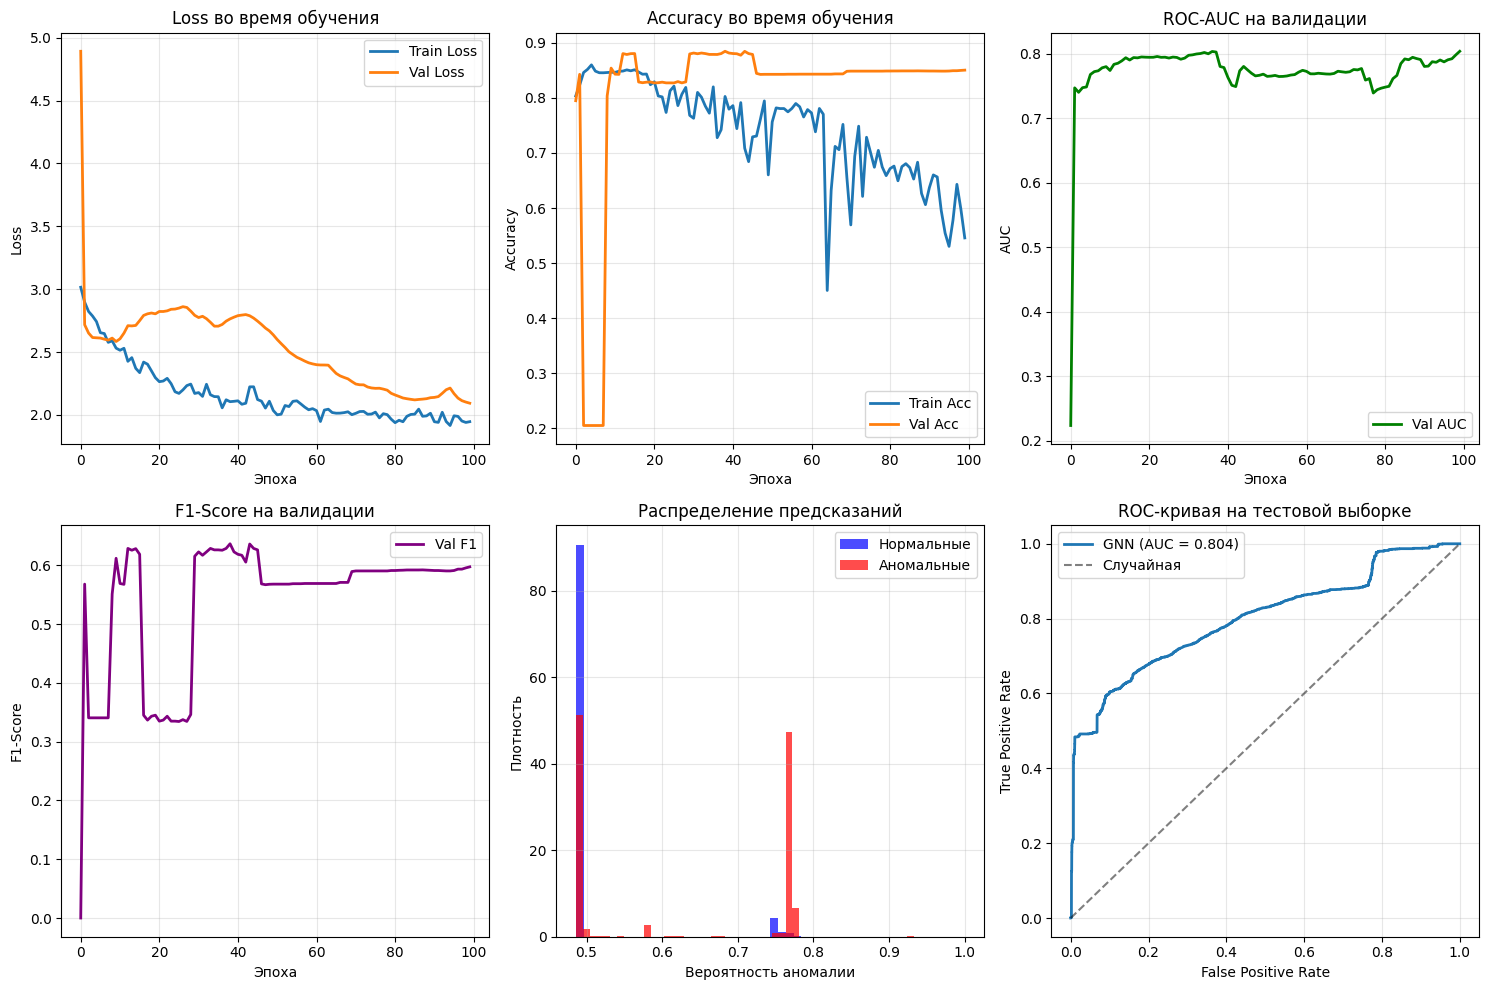

In [41]:
def plot_training_history(history):
    """Визуализация истории обучения"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss во время обучения')
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[0, 1].set_title('Accuracy во время обучения')
    axes[0, 1].set_xlabel('Эпоха')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[0, 2].plot(history['val_auc'], label='Val AUC', linewidth=2, color='green')
    axes[0, 2].set_title('ROC-AUC на валидации')
    axes[0, 2].set_xlabel('Эпоха')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    axes[1, 0].plot(history['val_f1'], label='Val F1', linewidth=2, color='purple')
    axes[1, 0].set_title('F1-Score на валидации')
    axes[1, 0].set_xlabel('Эпоха')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    model.eval()
    with torch.no_grad():
        test_edges = graph_data.edge_index[:, graph_data.test_mask]
        test_edge_attr = graph_data.edge_attr[graph_data.test_mask] if graph_data.edge_attr is not None else None
        test_targets = graph_data.y[graph_data.test_mask]
        
        test_pred = model(graph_data.x, test_edges, test_edge_attr)
        test_pred_proba = torch.sigmoid(test_pred).cpu().numpy()
        test_targets_np = test_targets.cpu().numpy()
    
    axes[1, 1].hist(test_pred_proba[test_targets_np == 0], 
                   bins=50, alpha=0.7, label='Нормальные', color='blue', density=True)
    axes[1, 1].hist(test_pred_proba[test_targets_np == 1], 
                   bins=50, alpha=0.7, label='Аномальные', color='red', density=True)
    axes[1, 1].set_title('Распределение предсказаний')
    axes[1, 1].set_xlabel('Вероятность аномалии')
    axes[1, 1].set_ylabel('Плотность')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(test_targets_np, test_pred_proba)
    axes[1, 2].plot(fpr, tpr, label=f'GNN (AUC = {history["val_auc"][-1]:.3f})', linewidth=2)
    axes[1, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Случайная')
    axes[1, 2].set_title('ROC-кривая на тестовой выборке')
    axes[1, 2].set_xlabel('False Positive Rate')
    axes[1, 2].set_ylabel('True Positive Rate')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return test_pred_proba, test_targets_np

test_pred_proba, test_targets_np = plot_training_history(history)

In [56]:
def evaluate_model(model, data):
    """Полная оценка модели на тестовой выборке"""
    model.eval()
    
    with torch.no_grad():
        test_edges = data.edge_index[:, data.test_mask]
        test_edge_attr = data.edge_attr[data.test_mask] if data.edge_attr is not None else None
        test_targets = data.y[data.test_mask]
        
        test_pred = model(data.x, test_edges, test_edge_attr)
        test_pred_proba = torch.sigmoid(test_pred)
        test_pred_binary = (test_pred_proba > 0.5).float()
    
    y_true = test_targets.cpu().numpy().flatten()
    y_pred = test_pred_binary.cpu().numpy().flatten()
    y_pred_proba = test_pred_proba.cpu().numpy().flatten()
        
    print("Классификационный отчет:")
    print(classification_report(y_true, y_pred, target_names=['Нормальные', 'Аномальные']))
    
    print("Матрица ошибок:")
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, 
                         index=['Факт: Норма', 'Факт: Аномалия'], 
                         columns=['Прогноз: Норма', 'Прогноз: Аномалия'])
    print(cm_df)
    
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        },
        'confusion_matrix': cm
    }

results = evaluate_model(model, graph_data)

Классификационный отчет:
              precision    recall  f1-score   support

  Нормальные       0.89      0.93      0.91      8622
  Аномальные       0.65      0.53      0.59      2066

    accuracy                           0.85     10688
   macro avg       0.77      0.73      0.75     10688
weighted avg       0.85      0.85      0.85     10688

Матрица ошибок:
                Прогноз: Норма  Прогноз: Аномалия
Факт: Норма               8039                583
Факт: Аномалия             970               1096


Итоговые метрики:

In [61]:
results['metrics']

{'accuracy': np.float64(0.8546968562874252),
 'precision': np.float64(0.6527695056581299),
 'recall': np.float64(0.5304937076476283),
 'f1': 0.5853137516688919,
 'roc_auc': 0.800216324524287,
 'pr_auc': 0.6399302329411918}